#### 久保拓弥，データ解析のための統計モデリング入門 一般化線形モデル・階層ベイズモデル・MCMC，岩波書店 2012．
## 8章 マルコフ連鎖モンテカルロ (MCMC) 法とベイズ統計モデル

ある植物の20個体から得た種子8個のうち、発芽したものをカウントした結果を$Y=(4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4)$とする。

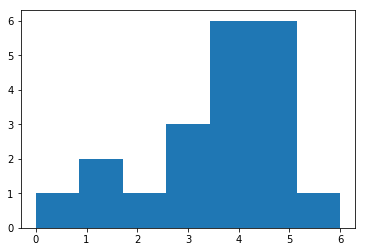

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

Y = [4,3,4,5,5,2,3,1,4,0,1,5,5,6,5,4,4,5,3,4]
plt.hist(Y, bins=7)
plt.show()

この$Y$が二項分布に従うと仮定する。
均質な20個体の種子生存確率を$q$とすると、ある個体$i$の種子が生存する確率は次のように書ける：
$$
p(y_i\mid q)=\begin{pmatrix}8 \\ y_i\end{pmatrix} q^y_i (1-q)^{8-y_i}.
$$
このときの尤度関数$L$は次のように書ける：
$$
L(q)=p(Y\mid q)=\prod_{i=1}^{20}p(y_i\mid q).
$$
対数尤度関数は次のようになる：
$$
\log L(q)=\sum_{i=1}^{20}\left( y_i \log q +(8-y_i)\log (1-q) + \log \begin{pmatrix}8 \\ y_i\end{pmatrix}\right).
$$

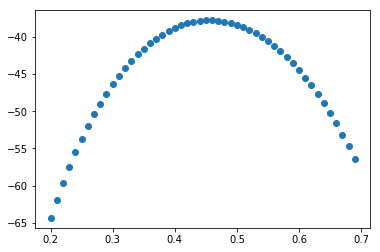

In [2]:
# nCrの計算
def comb(n, r):
    return math.factorial(n) // (math.factorial(n - r) * math.factorial(r))

# 対数尤度関数
def logL(x):
    ell = sum([y * np.log(x) for y in Y]) + sum([(8-y)*np.log(1-x) for y in Y]) + sum([np.log(comb(8, y)) for y in Y])
    return ell

# プロット
x = np.arange(0.2,0.7,0.01)
plt.plot(x, logL(x), 'o')
plt.show()

この対数尤度関数$\log L(q)$を最大化する$\hat{q}$を求めたい。

対数尤度関数の傾きが0になる点を求める：
\begin{align}
&\frac{d\log L(q)}{dq} = \sum_{i=1}^{20}\left(\frac{y_i}{q}-\frac{8-y_i}{1-q}\right)=0 \\
\Longrightarrow &\quad q=\frac{73}{160}=0.4625.
\end{align}

この対数尤度関数を最大化する点を解析的に求めることが難しいなら、試行錯誤的によって$q$を少しずつ変化させることで、対数尤度が高くなる$\hat{q}$を探し出せる。

まず、連続な値を取るはずの$q$を離散化する。
次に適当な初期値を選び$q_0, i=0$とする。
確率$\frac{1}{2}$で$q_i + 0.01$、確率$\frac{1}{2}$で$q_i - 0.01$を選び、対数尤度関数が改善するなら値を更新する。

In [3]:
# ふらふら最尤推定
def furafura(f, q, iter=100):
    q0 = q
    seq = []
    for _ in range(iter):
        q1 = q0 + 0.01 if np.random.rand() < 0.5 else q0 - 0.01
        if f(q0) < f(q1):
            q0 = q1
        seq.append(q0)
    return seq

seq = furafura(logL, 0.1)
print(seq[-1])

0.4600000000000003


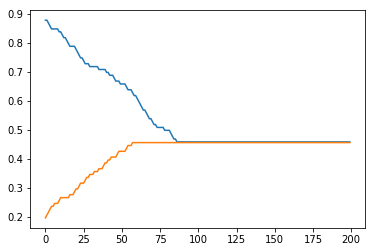

In [4]:
seq1 = furafura(logL, np.random.rand(), 200)
seq2 = furafura(logL, np.random.rand(), 200)

plt.plot(seq1)
plt.plot(seq2)
plt.show()

In [5]:
# scipy の optimize 関数を利用
from scipy import optimize
# なぜか warning が出るので無視する
import warnings
warnings.filterwarnings('ignore', 'The iteration is not making good progress')

x0 = optimize.fsolve(logL, x0=0.1, xtol=1e-06, maxfev=100)
print(x0)

[ 0.45640504]


MCMCアルゴリズムのひとつであるメトロポリス法は、上のふらふら最尤法に新しいルールを加えたもの。
そのルールは「対数尤度関数が改善しなくても、確率$r$で$q$の値を更新する」というもの。

In [6]:
# メトロポリス法
def metro(f, x=0.1, iter=1000):
    x0 = x
    seq = []
    for _ in range(iter):
        x1 = x0 + 0.01 if np.random.rand() < 0.5 else x0 - 0.01
        if f(x0) < f(x1):
            x0 = x1
        elif np.random.rand() < np.exp(logL(x1) - logL(x0)):
            x0 = x1
        seq.append(x0)
    return seq

サンプル列が定常分布に収束しているか、図を描いて確認してみる。

In [7]:
seq = metro(logL, 0.3)

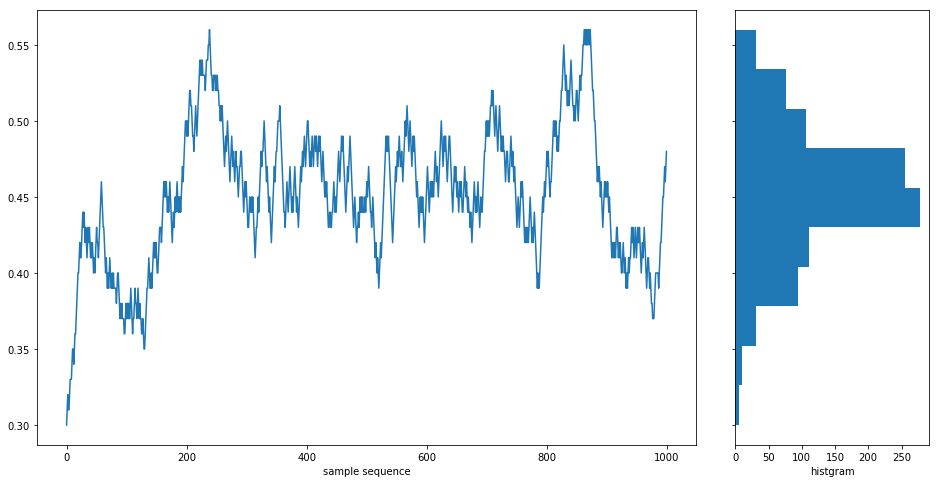

In [8]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec     # グラフの配置を複雑にする
import numpy as np

fig = plt.figure(figsize=(16,8))

# 描画範囲を1行4列に分割
# 系列データを0行目0:3列目に配置
# ヒストグラムを0行目3列目に配置
gs = GridSpec(1,4)
ax_seq = fig.add_subplot(gs[0, 0:3])
ax_hist = fig.add_subplot(gs[0, 3])

ax_seq.plot(seq)
ax_hist.hist(seq,orientation="horizontal")

# 右側ヒストグラムの軸を消去
plt.setp(ax_hist.get_yticklabels(), visible=False)

# ラベル名
ax_seq.set_xlabel('sample sequence')
ax_hist.set_xlabel('histgram')
plt.show()

In [9]:
seq1 = metro(logL, np.random.rand(), 1000)
seq2 = metro(logL, np.random.rand(), 1000)
seq3 = metro(logL, np.random.rand(), 1000)

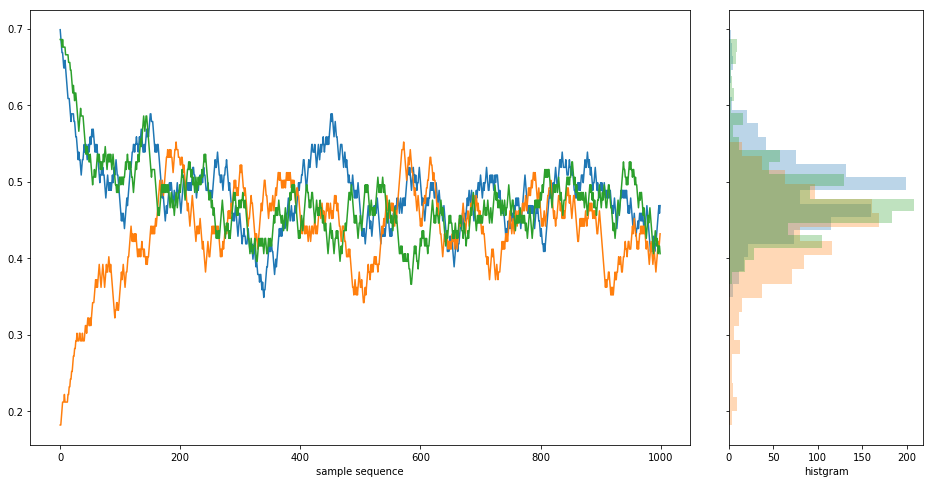

In [10]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec     # グラフの配置を複雑にする
import numpy as np

fig = plt.figure(figsize=(16,8))

# 描画範囲を1行4列に分割
# 系列データを0行目0:3列目に配置
# ヒストグラムを0行目3列目に配置
gs = GridSpec(1,4)
ax_seq = fig.add_subplot(gs[0, 0:3])
ax_hist = fig.add_subplot(gs[0, 3])

ax_seq.plot(seq1)
ax_seq.plot(seq2)
ax_seq.plot(seq3)
ax_hist.hist(seq1,orientation="horizontal", alpha=0.3, bins=20)
ax_hist.hist(seq2,orientation="horizontal", alpha=0.3, bins=20)
ax_hist.hist(seq3,orientation="horizontal", alpha=0.3, bins=20)

# 右側ヒストグラムの軸を消去
plt.setp(ax_hist.get_yticklabels(), visible=False)

# ラベル名
ax_seq.set_xlabel('sample sequence')
ax_hist.set_xlabel('histgram')
plt.show()

実はこのメトロポリス法によって得られたサンプル列の分布は、「定常分布」になっている。
この定常分布の平均値・中央値・標準偏差・95%区間といった統計量を評価すれば、$q$の分布の要約が得られ、これらの情報からは推定されたパラメータの分布と現象の対応関係の検討が可能である。